## Normal Equation

In [ ]:
!pip install category_encoders
!pip install mord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=cc2aa0fcba2c325f4775b787353f7e43835e6418db70872fc4a74f5146b1ca05
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


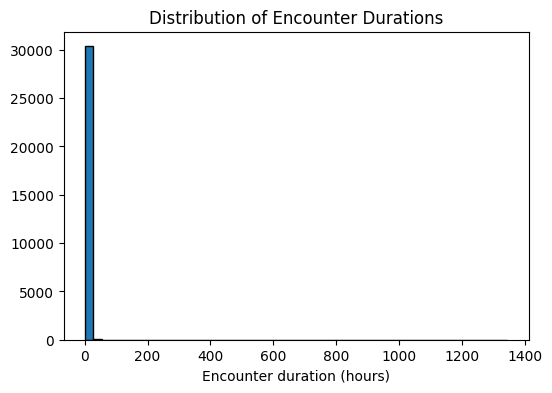

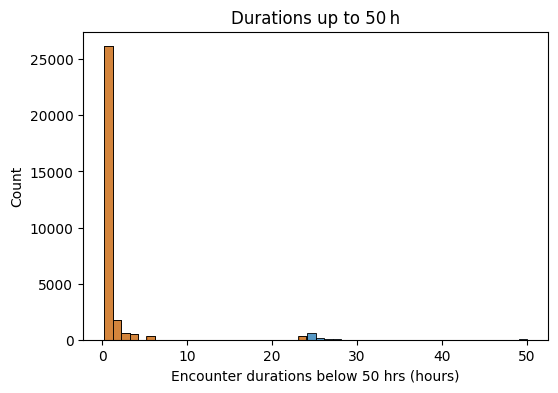

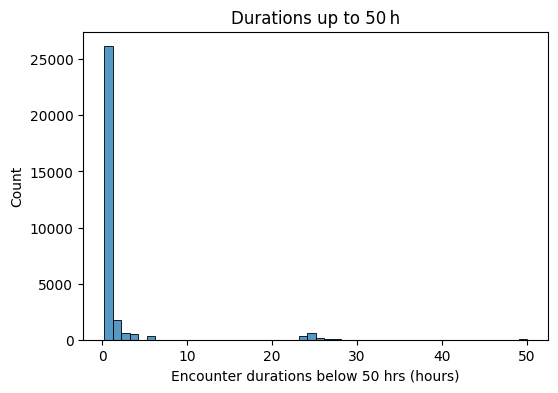

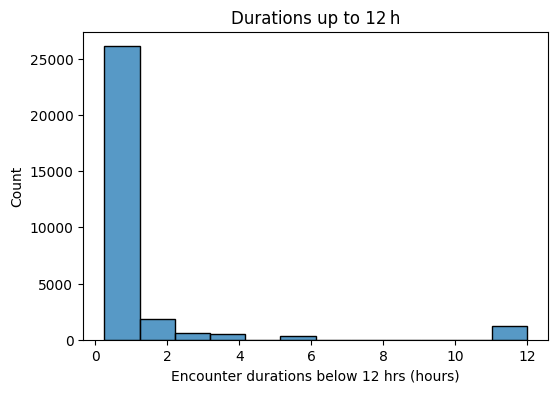

,Id,DURATION_HOURS,START,PATIENTID,GENDER,PATIENT_AGE_AT_ENCOUNTER,HAD_ALLERGY,BASE_ENCOUNTER_COST,ORGNAME,ORGTRAFFIC,...,PATIENT_MEDICATION_COUNT,TOTAL_MEDICATIONS_BASE_COST,PATIENT_IMMUNIZATION_COUNT,PREVIOUS_PROCEDURE_COUNT,HAD_IMAGING,START_HOUR,START_WEEKDAY,START_MONTH,IS_HOLIDAY,DURATION_CAP
0,000186d2-1316-4b58-be65-272233953fcb,1.50,2014-12-03 13:12:11+00:00,8be62b06-5994-47fe-aad8-a27a02e054fa,F,27.0,False,129.16,MORTON HOSPITAL,1682,...,0,0.0000,4,95,False,13,2,12,0,1.50
1,0002adbb-59c3-494a-bb17-0d1acc692ae8,0.85,2014-12-06 12:52:02+00:00,1e52e4fe-13c7-41ad-8b3e-5933fdd553c4,F,16.0,False,129.16,COOLEY DICKINSON HOSPITAL INC THE,1641,...,2,274.0100,2,55,False,12,5,12,0,0.85
2,0005b0a0-1b05-40ec-a741-11c116654840,0.55,2018-02-20 01:11:43+00:00,ef0e5433-6dab-4608-86e4-5b2fb9647d2d,F,40.0,False,129.16,FALMOUTH HOSPITAL,1728,...,2,1339.8400,2,57,False,1,1,2,0,0.55
3,000c97b3-5832-4ecc-8a47-76c0197fffe4,0.25,2018-11-17 22:09:56+00:00,3dd2dd29-7cd0-48f7-b859-136c6e9d36e0,M,98.0,False,129.16,NEWTON-WELLESLEY HOSPITAL,2658,...,4,2277.1099,2,33,False,22,5,11,0,0.25
4,000c9d31-d256-4308-91a3-cf4181178ba2,0.25,2015-09-04 09:49:43+00:00,b44b3fde-b4bd-46eb-8ced-caccab915738,F,49.0,False,129.16,PCP36993,62,...,1,526.9800,1,5,False,9,4,9,0,0.25


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import CatBoostEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


# Load CSV

encounters_df = pd.read_csv("encounter_patient_info_v3.csv")

encounters_df['TOTAL_MEDICATIONS_BASE_COST'] = encounters_df['TOTAL_MEDICATIONS_BASE_COST'].fillna(0)

"""
I ran all of this without the target being capped and the models have a R-squared of around 0.41 but capping the
values using the IQR method resulted in a much greater accuracy. This took away to much data as using the IQR method
capped the target at 1 hour only which is way to small so i increased it to cover the 0.99 quantile of the data which
will be capping at 50 hours. There are no data points at exactly 50 hours so our data being capped at 50 hours can be
defined to be understood as above 50 hours. I later get into possibly splitting our enconter durations into class duration
later in this notebook if you want to take a look at that.
"""



X = encounters_df.drop(columns=['DURATION_HOURS', 'Id', 'START', 'PATIENTID', 'ORGSPECIALITY'])
y = encounters_df['DURATION_HOURS']

# plot of target
plt.figure(figsize=(6,4))
plt.hist(y, bins=50, edgecolor='k')
plt.xlabel('Encounter duration (hours)')
plt.title('Distribution of Encounter Durations')
plt.show()

# create a capped target
encounters_df['DURATION_CAP'] = encounters_df['DURATION_HOURS'].clip(upper=cap)

X = encounters_df.drop(columns=['DURATION_HOURS', 'Id', 'START', 'PATIENTID', 'DURATION_CAP', 'ORGSPECIALITY'])  # droping non-predictive IDs
y = encounters_df['DURATION_CAP']

# plot of where most of the data is at
plt.figure(figsize=(6,4))
sns.histplot(y, bins=50, kde=False)
sns.histplot(y[y <= 24], bins=24, kde=False)
plt.xlabel('Encounter durations below 50 hrs (hours)')
plt.title('Durations up to 50 h')
plt.show()

# create a capped target
# compute the target cap to handle very extreme outliers
cap = encounters_df['DURATION_HOURS'].clip(upper = 50)
encounters_df['DURATION_CAP'] = encounters_df['DURATION_HOURS'].clip(upper=cap)

X = encounters_df.drop(columns=['DURATION_HOURS', 'Id', 'START', 'PATIENTID', 'DURATION_CAP', 'ORGSPECIALITY'])  # droping non-predictive IDs
y = encounters_df['DURATION_CAP']

# plot of where most of the data is at
plt.figure(figsize=(6,4))
sns.histplot(y, bins=50, kde=False)
plt.xlabel('Encounter durations below 50 hrs (hours)')
plt.title('Durations up to 50 h')
plt.show()



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# using CatBoostEncoder to encode our high-cardinality categorical features
#what it does: Encodes categorical features as smoothed, out-of-fold target means (no leakage; rare/unseen levels => global mean)
encoder = CatBoostEncoder(cols=X_train.select_dtypes(include=['object','bool']).columns, random_state=42)

X_train_enc = encoder.fit_transform(X_train, y_train)
X_test_enc  = encoder.transform(X_test)

scaler = StandardScaler() # scaling for gradient descent
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled  = scaler.transform(X_test_enc)

encounters_df.describe()

encounters_df.head()

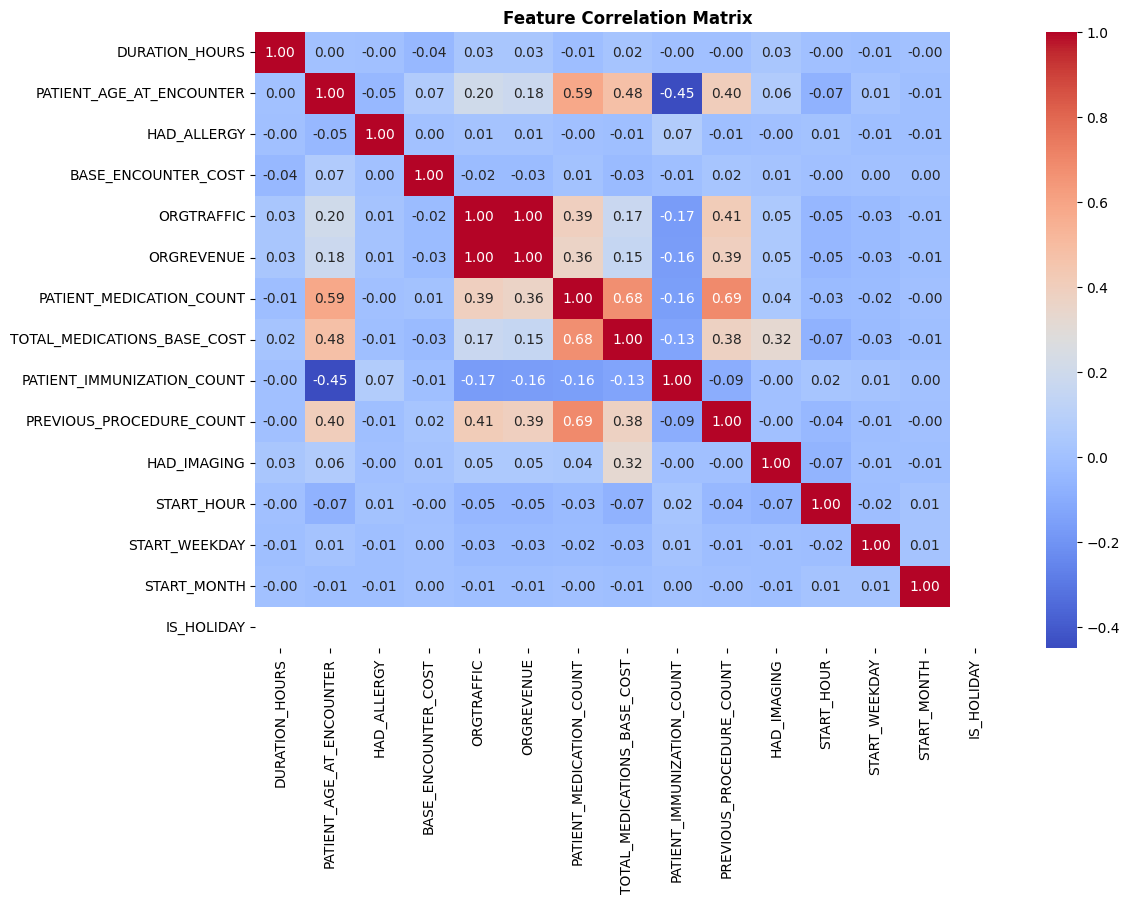

In [ ]:

# Create Correlation matrix
correlation_matrix = encounters_df.corr(numeric_only=True)

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix", fontweight='bold')
plt.show()

In [ ]:
# Predict on training data
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
preds = lr.predict(X_test_scaled)

rmse = mean_squared_error(y_test, preds) ** 0.5
r2   = r2_score(y_test, preds)

# This tracks the how the variance is related. Low = bad.
print(f"\nR² score: {r2:.4f}\n")

# MSE
print(f"Test RMSE: {rmse:.4f}")


R² score: 0.8839

Test RMSE: 1.7425


In [ ]:
# Display coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_
})

# Round to 4 decimals
coef_df = coef_df.round(4)

# absolute value of coefficient helps us see negative/positive correlation
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

print(coef_df)

                        Feature  Coefficient
7                ENCOUNTERCLASS       4.4726
9             REASONDESCRIPTION       2.3342
2           BASE_ENCOUNTER_COST       0.9776
8                   DESCRIPTION      -0.4156
11  TOTAL_MEDICATIONS_BASE_COST       0.2720
12     PREVIOUS_PROCEDURE_COUNT       0.2116
1      PATIENT_AGE_AT_ENCOUNTER      -0.2034
10     PATIENT_MEDICATION_COUNT      -0.1138
0                        GENDER      -0.1003
4                    ORGTRAFFIC       0.0782
3                       ORGNAME      -0.0711
6                          CITY       0.0646
5                    ORGREVENUE      -0.0315
13                   START_HOUR       0.0162
14                START_WEEKDAY      -0.0151


In [ ]:
# will try new model with polynomial features to test for interactions

# polynomial features

poly = PolynomialFeatures(degree=2, include_bias=False) # any degree above 2 results in a reduction to R^2 so less accurate (also degree 4 runs for 30+ mins lol)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly  = poly.transform(X_test_scaled)

# fitting new linear regression
poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train)
preds = poly_lr.predict(X_test_poly)

# evaluations
rmse = mean_squared_error(y_test, preds) ** 0.5
r2   = r2_score(y_test, preds)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²:   {r2:.4f}")

# saw a slightly improvement in R^2 and RMSE



Test RMSE: 1.4299
Test R²:   0.9218


In [ ]:
"""
# log-transformation on the target variable as we know that our target is very right skewed
y_log = np.log(y)

# resplitting the training and test data with new transformation
X_train, X_test, y_train_log, y_test_log, y_train, y_test = train_test_split(
    X, y_log, y, test_size=0.3, random_state=42
)

# reencoding categoricals
cat_cols = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()
encoder = CatBoostEncoder(cols=cat_cols, random_state=42)
X_train_enc = encoder.fit_transform(X_train, y_train_log)
X_test_enc  = encoder.transform(X_test)

log_lr = LinearRegression()
log_lr.fit(X_train_enc, y_train_log)

# 6. Predict (in log space) and back-transform
preds_log = lr.predict(X_test_enc)
preds = np.expm1(preds_log)  # inverse of log1p

# 7. Evaluate on original scale
rmse = mean_squared_error(y_test, preds_log) ** 0.5
r2   = r2_score(y_test, preds_log)

print(f"Test RMSE (hrs): {rmse:.4f}")
print(f"Test R²:         {r2:.4f}")
"""
print(" ")
# results in an much worse R^2 and so did trying a sqrt transformation so sticking with no transformation in the target variable.

## Gradient Descent

In [ ]:
# Fit SGD on scaled features. This seems to not be able to handle the polynomial features as even after adjustments to rates and other parameters it still would not converge even after 10000 iterations.
sgd_model = SGDRegressor(
    loss='squared_error',     # ordinary least squares
    penalty='l2',            # ridge regularization; set to None to disable
    alpha=1e-3,            # regularization strength
    learning_rate='invscaling',
    eta0=0.01,
    max_iter=1000,
    tol=1e-4,
    random_state=42,
    verbose=1                # prints progress every epoch
)

sgd_model.fit(X_train_scaled, y_train)

# Predict on training data
y_pred = sgd_model.predict(X_test_scaled)

# Evaluation output
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print(f"\nR² score: {r2:.4f}\n")
print(f"RMSE: {rmse:.4f}\n")
print(f"Intercept: {sgd_model.intercept_[0]:.4f}\n")

-- Epoch 1
Norm: 5.29, NNZs: 15, Bias: 1.781090, T: 21354, Avg. loss: 2.526132
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 5.18, NNZs: 15, Bias: 1.683018, T: 42708, Avg. loss: 2.349585
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 5.18, NNZs: 15, Bias: 1.780736, T: 64062, Avg. loss: 2.321809
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 5.06, NNZs: 15, Bias: 1.689128, T: 85416, Avg. loss: 2.322291
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 5.13, NNZs: 15, Bias: 1.698860, T: 106770, Avg. loss: 2.332270
Total training time: 0.04 seconds.
-- Epoch 6
Norm: 5.03, NNZs: 15, Bias: 1.661070, T: 128124, Avg. loss: 2.326256
Total training time: 0.04 seconds.
-- Epoch 7
Norm: 5.07, NNZs: 15, Bias: 1.707158, T: 149478, Avg. loss: 2.296967
Total training time: 0.05 seconds.
-- Epoch 8
Norm: 5.20, NNZs: 15, Bias: 1.730282, T: 170832, Avg. loss: 2.322098
Total training time: 0.05 seconds.
-- Epoch 9
Norm: 5.10, NNZs: 15, Bias: 1.734396, T: 192186, Avg. loss: 2.313038
Tota

In [ ]:
# Display coefficients


# absolute value of coefficient helps us see negative/positive correlation
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

pd.set_option('display.float_format', '{:.4f}'.format)

print(coef_df)

                        Feature  Coefficient
7                ENCOUNTERCLASS       4.4726
9             REASONDESCRIPTION       2.3342
2           BASE_ENCOUNTER_COST       0.9776
8                   DESCRIPTION      -0.4156
11  TOTAL_MEDICATIONS_BASE_COST       0.2720
12     PREVIOUS_PROCEDURE_COUNT       0.2116
1      PATIENT_AGE_AT_ENCOUNTER      -0.2034
10     PATIENT_MEDICATION_COUNT      -0.1138
0                        GENDER      -0.1003
4                    ORGTRAFFIC       0.0782
3                       ORGNAME      -0.0711
6                          CITY       0.0646
5                    ORGREVENUE      -0.0315
13                   START_HOUR       0.0162
14                START_WEEKDAY      -0.0151


Possible change to response variable to be a classification. of the form

| Class     | Range (hours) | Suggested name           |
| --------- | ------------- | ------------------------ |
| Quick     | exactly 0.25  | “Quick”                  |
| Short     | (0.25, 1]     | “Short”                  |
| Moderate  | (1, 6]        | “Moderate”               |
| Long      | (6, 24]       | “Long”                   |
| Very Long | (24, 50]      | “Very Long”              |
| Extreme   | > 50          | “Extreme”               |


In [ ]:
# Setting bins for the classes
bins   = [-float('inf'), 0.25, 1, 6, 24, 50, float('inf')]
labels = [
    'Quick (≤0.25h)',
    'Short (0.25–1h]',
    'Moderate (1–6h]',
    'Long (6–24h]',
    'Very Long (24–50h]',
    'Extreme (>50h)'
]


encounters_df['ENCOUNTER_LENGTH_CLASS'] = pd.cut(
    encounters_df['DURATION_HOURS'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# some class counts have view observations so it could be very unbalanced (need to account for this latter)
counts = encounters_df['ENCOUNTER_LENGTH_CLASS'].value_counts().reindex(labels)
print(counts)
encounters_df.head()

ENCOUNTER_LENGTH_CLASS
Quick (≤0.25h)        14352
Short (0.25–1h]       11151
Moderate (1–6h]        3775
Long (6–24h]            306
Very Long (24–50h]      831
Extreme (>50h)           91
Name: count, dtype: int64


,Id,DURATION_HOURS,START,PATIENTID,GENDER,PATIENT_AGE_AT_ENCOUNTER,HAD_ALLERGY,BASE_ENCOUNTER_COST,ORGNAME,ORGTRAFFIC,...,TOTAL_MEDICATIONS_BASE_COST,PATIENT_IMMUNIZATION_COUNT,PREVIOUS_PROCEDURE_COUNT,HAD_IMAGING,START_HOUR,START_WEEKDAY,START_MONTH,IS_HOLIDAY,DURATION_CAP,ENCOUNTER_LENGTH_CLASS
0,000186d2-1316-4b58-be65-272233953fcb,1.5000,2014-12-03 13:12:11+00:00,8be62b06-5994-47fe-aad8-a27a02e054fa,F,27.0000,False,129.1600,MORTON HOSPITAL,1682,...,0.0000,4,95,False,13,2,12,0,1.5000,Moderate (1–6h]
1,0002adbb-59c3-494a-bb17-0d1acc692ae8,0.8500,2014-12-06 12:52:02+00:00,1e52e4fe-13c7-41ad-8b3e-5933fdd553c4,F,16.0000,False,129.1600,COOLEY DICKINSON HOSPITAL INC THE,1641,...,274.0100,2,55,False,12,5,12,0,0.8500,Short (0.25–1h]
2,0005b0a0-1b05-40ec-a741-11c116654840,0.5500,2018-02-20 01:11:43+00:00,ef0e5433-6dab-4608-86e4-5b2fb9647d2d,F,40.0000,False,129.1600,FALMOUTH HOSPITAL,1728,...,1339.8400,2,57,False,1,1,2,0,0.5500,Short (0.25–1h]
3,000c97b3-5832-4ecc-8a47-76c0197fffe4,0.2500,2018-11-17 22:09:56+00:00,3dd2dd29-7cd0-48f7-b859-136c6e9d36e0,M,98.0000,False,129.1600,NEWTON-WELLESLEY HOSPITAL,2658,...,2277.1099,2,33,False,22,5,11,0,0.2500,Quick (≤0.25h)
4,000c9d31-d256-4308-91a3-cf4181178ba2,0.2500,2015-09-04 09:49:43+00:00,b44b3fde-b4bd-46eb-8ced-caccab915738,F,49.0000,False,129.1600,PCP36993,62,...,526.9800,1,5,False,9,4,9,0,0.2500,Quick (≤0.25h)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# setting up our training and test data again
X = encounters_df.drop(columns=['DURATION_HOURS', 'Id', 'START', 'PATIENTID', 'DURATION_CAP', 'ENCOUNTER_LENGTH_CLASS'])  # droping non-predictive IDs
y = encounters_df['ENCOUNTER_LENGTH_CLASS']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# using CatBoostEncoder to encode our high-cardinality categorical features
#what it does: Encodes categorical features as smoothed, out-of-fold target means (no leakage; rare/unseen levels => global mean)
encoder = CatBoostEncoder(cols=X_train.select_dtypes(include=['object','bool']).columns, random_state=42)

X_train_enc = encoder.fit_transform(X_train, y_train)
X_test_enc  = encoder.transform(X_test)

# scaling again
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled  = scaler.transform(X_test_enc)


# setting up regression
multi_log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced',# balance set since our bin counts are very different
    max_iter=1000,
    random_state=42
)

# fit
multi_log_reg.fit(X_train_scaled, y_train)

# prediction and evaluation
y_pred = multi_log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(confusion_matrix(   y_test, y_pred))

                    precision    recall  f1-score   support

    Extreme (>50h)       0.19      1.00      0.32        20
      Long (6–24h]       0.82      0.90      0.86        83
   Moderate (1–6h]       0.43      0.64      0.51      1154
    Quick (≤0.25h)       0.74      0.72      0.73      4318
   Short (0.25–1h]       0.66      0.54      0.59      3333
Very Long (24–50h]       0.97      0.93      0.95       244

          accuracy                           0.66      9152
         macro avg       0.63      0.79      0.66      9152
      weighted avg       0.67      0.66      0.66      9152

[[  20    0    0    0    0    0]
 [   2   75    0    0    0    6]
 [  14    0  742   83  315    0]
 [  65    2  512 3127  611    1]
 [   0    1  485 1042 1804    1]
 [   3   13    0    0    1  227]]




```
# This is formatted as code
```

overall around 0.66 precision avg with some classes having more precise predictions than others.

In [ ]:
# trying polynomial features

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly  = poly.transform(X_test_scaled)


# setting up regression
multi_log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced',# balance set since our bin counts are ver different
    max_iter=10000,
    random_state=42
)

# fit
multi_log_reg.fit(X_train_poly, y_train)

# prediction and evaluation lead to the precion increasing to 0.73
y_pred = multi_log_reg.predict(X_test_poly)
print(classification_report(y_test, y_pred))
print(confusion_matrix(   y_test, y_pred))

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
"""
import numpy as np
from mord import OrdinalRidge
from sklearn.metrics import classification_report, confusion_matrix

encounters_df['ORD_TARGET'] = encounters_df['ENCOUNTER_LENGTH_CLASS'].cat.codes

X = encounters_df.drop(columns=['DURATION_HOURS', 'Id', 'START', 'PATIENTID', 'DURATION_CAP', 'ORGSPECIALITY', 'ENCOUNTER_LENGTH_CLASS', 'ORD_TARGET'])  # droping non-predictive IDs
y = encounters_df['ORD_TARGET']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

encoder = CatBoostEncoder(cols=X_train.select_dtypes(include=['object','bool']).columns, random_state=42)

X_train_enc = encoder.fit_transform(X_train, y_train)
X_test_enc  = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled  = scaler.transform(X_test_enc)

counts     = np.bincount(y_train)
total      = len(y_train)
n_classes  = len(counts)
class_wts  = {i: total / (n_classes * cnt) for i, cnt in enumerate(counts)}

# 2) Build a sample‐weight array aligned with y_train
sample_weight = np.array([ class_wts[label] for label in y_train ])

# 3) Instantiate and fit your ordinal model *with* weights
ord_ridge = OrdinalRidge(alpha=1.0)
ord_ridge.fit(X_train_scaled, y_train, sample_weight=sample_weight)

# 4) Then predict & evaluate as before
pred_codes  = np.clip(np.rint(ord_ridge.predict(X_test_scaled)), 0, n_classes-1).astype(int)
labels      = list(encounters_df['ENCOUNTER_LENGTH_CLASS'].cat.categories)
pred_labels = [labels[c] for c in pred_codes]
true_labels = encounters_df.loc[X_test.index, 'ENCOUNTER_LENGTH_CLASS'].tolist()

# 5. Evaluate
print(classification_report(true_labels, pred_labels))
print(confusion_matrix(true_labels, pred_labels))

# Much worse results than the polynomial logistic regression model.
"""

                    precision    recall  f1-score   support

    Extreme (>50h)       0.42      0.95      0.58        20
      Long (6–24h]       0.33      0.84      0.48        83
   Moderate (1–6h]       0.49      0.77      0.60      1154
    Quick (≤0.25h)       0.98      0.14      0.25      4318
   Short (0.25–1h]       0.40      0.75      0.52      3333
Very Long (24–50h]       0.93      0.72      0.81       244

          accuracy                           0.47      9152
         macro avg       0.59      0.70      0.54      9152
      weighted avg       0.70      0.47      0.41      9152

[[  19    1    0    0    0    0]
 [   1   70    0    0    0   12]
 [   0   11  883    2  258    0]
 [   5   71  102  621 3519    0]
 [   0    7  806    9 2509    2]
 [  20   49    0    0    0  175]]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_selection import SelectFromModel

# Setting new bins for the classes
bins   = [-float('inf'), 0.25, 3, 8, 24, 50, float('inf')]
labels = [
    'Quick (≤0.25h)',
    'Short (0.25–3h]',
    'Moderate (3–8h]',
    'Long (8–24h]',
    'Very Long (24–50h]',
    'Extreme (>50h)'
]


encounters_df['ENCOUNTER_LENGTH_CLASS'] = pd.cut(
    encounters_df['DURATION_HOURS'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# some class counts have view observations so it could be very unbalanced (need to account for this latter)
counts = encounters_df['ENCOUNTER_LENGTH_CLASS'].value_counts().reindex(labels)
print(counts)
encounters_df.head()

# setting up our training and test data again
X = encounters_df.drop(columns=['DURATION_HOURS', 'Id', 'START', 'PATIENTID', 'DURATION_CAP', 'ENCOUNTER_LENGTH_CLASS'])  # droping non-predictive IDs
y = encounters_df['ENCOUNTER_LENGTH_CLASS']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,          # important for classification
    random_state=42
)



#   Pack all preprocessing + model into one Pipeline
# ----------------------------------------------------
cat_cols = X_train.select_dtypes(include=['object','bool']).columns
print(cat_cols)
pipe = Pipeline([
    ("enc",  CatBoostEncoder(cols=cat_cols, random_state=42)),
    ("sc",   StandardScaler()),
    ("sfm",  SelectFromModel(
        LogisticRegression(
            solver="saga",
            penalty="l1",
            C=0.05,           # stronger L1 means fewer kept features
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        ),
        threshold="mean"
    )),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("clf",  LogisticRegression(
                 multi_class='multinomial',
                 solver='saga',
                 C=0.05,
                 class_weight='balanced',
                 max_iter=10000,
                 random_state=42))
])


#   3‑fold Stratified CV on the *training* fold
# -------------------------------------------------------------------
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_validate(
    pipe,
    X_train, y_train,
    cv=cv,
    scoring={
        "macro_f1": make_scorer(f1_score, average="macro"),
        "log_loss": "neg_log_loss"
    },
    n_jobs=-1
)

print(f"CV macro‑F1 : {scores['test_macro_f1'].mean():.3f} ± {scores['test_macro_f1'].std():.3f}")
print(f"CV log‑loss : {-scores['test_log_loss'].mean():.3f} ± {scores['test_log_loss'].std():.3f}")


# Final fit on *all* training data, then evaluate on the test set
# ---------------------------------------------------------------
# grab the fitted steps
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

enc  = pipe.named_steps['enc']    # CatBoostEncoder
sfm  = pipe.named_steps['sfm']    # SelectFromModel
poly = pipe.named_steps['poly']   # PolynomialFeatures
clf  = pipe.named_steps['clf']    # final LogisticRegression

# re‑encode TRAIN as a DataFrame (to restore column names)
X_enc_df      = enc.transform(X_train)
# find which columns survived the L1 selector
mask          = sfm.get_support()             # boolean mask
selected_cols = X_enc_df.columns[mask]

# getting real expanded names for only those selected columns
feat_names = poly.get_feature_names_out(selected_cols)

# extracting the coefficient matrix
# shape = (n_classes, n_features).
coefs = clf.coef_
imp   = np.linalg.norm(coefs, axis=0)  # one importance per feature

# build a sorted Series
feat_imp = pd.Series(imp, index=feat_names).sort_values(ascending=False)

# view
print("Top 5 features by coefficient magnitude:")
print(feat_imp.head(5))

print("\nTest set results:")
print(classification_report(
    y_test, y_pred,
    labels=labels,
    target_names=labels
))
print(confusion_matrix(y_test, y_pred, labels=labels))


ENCOUNTER_LENGTH_CLASS
Quick (≤0.25h)        14352
Short (0.25–3h]       14132
Moderate (3–8h]         794
Long (8–24h]            306
Very Long (24–50h]      831
Extreme (>50h)           91
Name: count, dtype: int64
Index(['GENDER', 'HAD_ALLERGY', 'ORGNAME', 'ORGSPECIALITY', 'CITY',
       'ENCOUNTERCLASS', 'DESCRIPTION', 'REASONDESCRIPTION', 'HAD_IMAGING'],
      dtype='object')
CV macro‑F1 : nan ± nan
CV log‑loss : 0.633 ± 0.031


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Top 5 features by coefficient magnitude:
BASE_ENCOUNTER_COST REASONDESCRIPTION              4.344337
DESCRIPTION^2                                      3.371842
BASE_ENCOUNTER_COST DESCRIPTION                    2.921899
BASE_ENCOUNTER_COST TOTAL_MEDICATIONS_BASE_COST    2.552483
DESCRIPTION                                        2.469293
dtype: float64

Test set results:
                    precision    recall  f1-score   support

    Quick (≤0.25h)       0.79      0.83      0.81      4306
   Short (0.25–3h]       0.82      0.70      0.75      4240
   Moderate (3–8h]       0.47      0.99      0.63       238
      Long (8–24h]       0.85      0.89      0.87        92
Very Long (24–50h]       0.71      0.98      0.82       249
    Extreme (>50h)       0.65      0.96      0.78        27

          accuracy                           0.78      9152
         macro avg       0.71      0.89      0.78      9152
      weighted avg       0.79      0.78      0.78      9152

[[3559  667   68    0 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid t

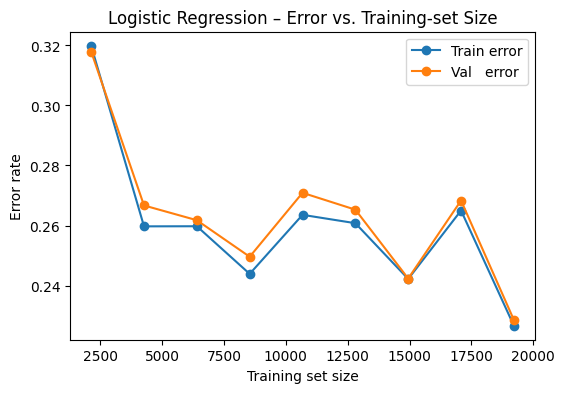

In [ ]:
# trying to get a error learning curve for

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from category_encoders import CatBoostEncoder
from sklearn.model_selection import train_test_split


# Make a DEV/VAL split of TRAINING set
# so we have X_dev / y_dev and X_val / y_val for the learning‑curve
# -----------------------------------------------------------------
X_dev, X_val, y_dev, y_val = train_test_split(
    X_train, y_train,
    test_size=0.20,
    stratify=y_train,
    random_state=42
)

#  Defining the base pipeline
pipe_base = Pipeline([
    ("enc",  CatBoostEncoder(cols=cat_cols, random_state=42)),
    ("sc",   StandardScaler()),
    ("sfm",  SelectFromModel(
        LogisticRegression(
            solver="saga",
            penalty="l1",
            C=0.05,
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        ),
        threshold="mean"
    )),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("clf",  LogisticRegression(
                 multi_class='multinomial',
                 solver='saga',
                 C=0.05,
                 class_weight='balanced',
                 max_iter=10000,
                 random_state=42))
])

#  Preparing arrays
fractions = np.linspace(0.1, 0.9, 9)      # 10 points from 10% to 100%
train_errs = []
val_errs   = []

for frac in fractions:
    # sub‑sample a fraction of X_train / y_train
    X_sub, _, y_sub, _ = train_test_split(
        X_train, y_train,
        train_size=float(frac),   # ensure Python float
        stratify=y_train,
        random_state=42
    )

    #  fitting pipeline on that subset
    pipe_base.fit(X_sub, y_sub)

    # computing error rate on subset & on a fixed validation set
    train_errs.append(1 - pipe_base.score(X_sub, y_sub))
    val_errs.append(  1 - pipe_base.score(X_val, y_val))

#  Plotting curve
sizes = fractions * len(X_train)
plt.figure(figsize=(6,4))
plt.plot(sizes, train_errs, marker='o', label="Train error")
plt.plot(sizes, val_errs,   marker='o', label="Val   error")
plt.xlabel("Training set size")
plt.ylabel("Error rate")
plt.title("Logistic Regression – Error vs. Training‑set Size")
plt.legend()
plt.show()